**OBJECTIVE**
To build and compare multiple time series forecasting models on monthly order data in order to capture trends and seasonal patterns, evaluate forecasting accuracy, and predict future order demand for the next 12 months.

In [81]:
import pandas as pd

orders = pd.read_csv("data/olist_orders_dataset.csv")
orders["order_purchase_timestamp"] = pd.to_datetime(
    orders["order_purchase_timestamp"]
)

monthly = (
    orders
    .groupby(pd.Grouper(key="order_purchase_timestamp", freq="MS"))
    .size()
    .reset_index(name="y")
)

monthly.columns = ["ds", "y"]
monthly = monthly.sort_values("ds")

print(monthly.head())
print("Total months:", len(monthly))

          ds    y
0 2016-09-01    4
1 2016-10-01  324
2 2016-11-01    0
3 2016-12-01    1
4 2017-01-01  800
Total months: 26


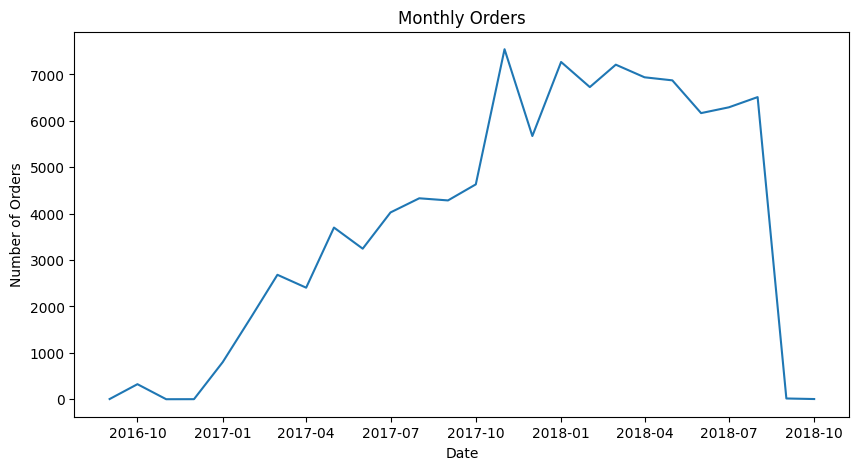

In [88]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(monthly["ds"], monthly["y"])
plt.title("Monthly Orders")
plt.xlabel("Date")
plt.ylabel("Number of Orders")
plt.show()

In [89]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(monthly["y"])

print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -0.5117685459665804
p-value: 0.8896994111413064


In [82]:
train = monthly.iloc[:-8]
test = monthly.iloc[-8:]

In [83]:
from statsmodels.tsa.arima.model import ARIMA
#ARIMA Model
model_arima = ARIMA(train["y"], order=(1,1,1))
model_arima_fit = model_arima.fit()

arima_forecast = model_arima_fit.forecast(steps=len(test))

In [84]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
sarima_model = SARIMAX(train["y"],order=(1,1,1),seasonal_order=(1,0,1,12),enforce_stationarity=False,enforce_invertibility=False).fit()

sarima_forecast = sarima_model.forecast(steps=len(test))

/home/ruchika-kaur/Documents/Brazilian_dataset_ML_NLP_Mini_Project/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/ruchika-kaur/Documents/Brazilian_dataset_ML_NLP_Mini_Project/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [85]:
from prophet import Prophet

prophet_train = train.reset_index()[["ds", "y"]]

model = Prophet()
model.fit(prophet_train)

future = model.make_future_dataframe(periods=len(test), freq='MS')
forecast = model.predict(future)

prophet_forecast = forecast.tail(len(test))["yhat"].values

20:30:01 - cmdstanpy - INFO - Chain [1] start processing


20:30:01 - cmdstanpy - INFO - Chain [1] done processing


In [86]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def evaluate(true, pred, name):
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    print(f"{name} MAE:", mae)
    print(f"{name} RMSE:", rmse)
    print("-"*30)

evaluate(test["y"], arima_forecast, "ARIMA")
evaluate(test["y"], sarima_forecast, "SARIMA")
evaluate(test["y"], prophet_forecast, "Prophet")

ARIMA MAE: 2188.4919214318215
ARIMA RMSE: 3612.963374349946
------------------------------
SARIMA MAE: 2815.789627756194
SARIMA RMSE: 4176.8776825932055
------------------------------
Prophet MAE: 4185.813980115731
Prophet RMSE: 5650.650945757698
------------------------------


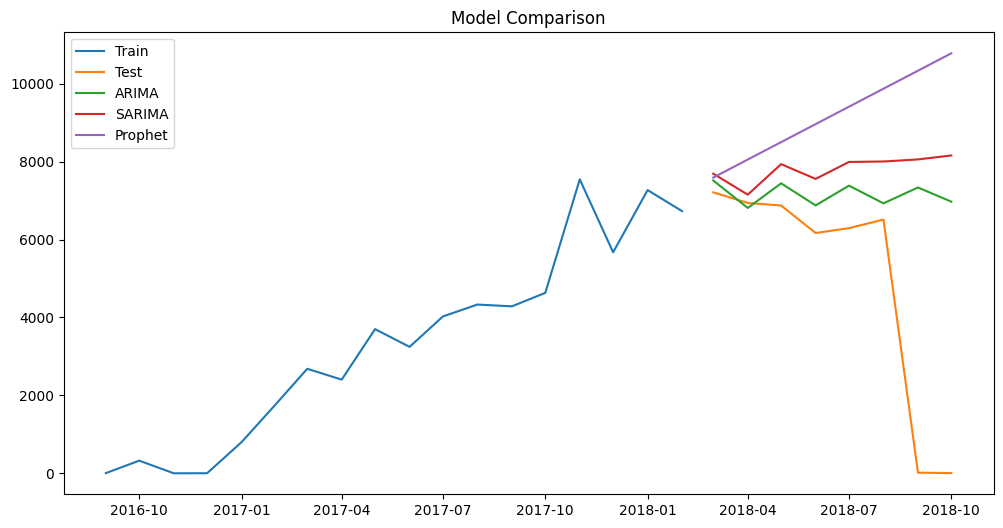

In [87]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

plt.plot(train["ds"], train["y"], label="Train")
plt.plot(test["ds"], test["y"], label="Test")

plt.plot(test["ds"], arima_forecast, label="ARIMA")
plt.plot(test["ds"], sarima_forecast, label="SARIMA")
plt.plot(test["ds"], prophet_forecast, label="Prophet")

plt.legend()
plt.title("Model Comparison")
plt.show()

/home/ruchika-kaur/Documents/Brazilian_dataset_ML_NLP_Mini_Project/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


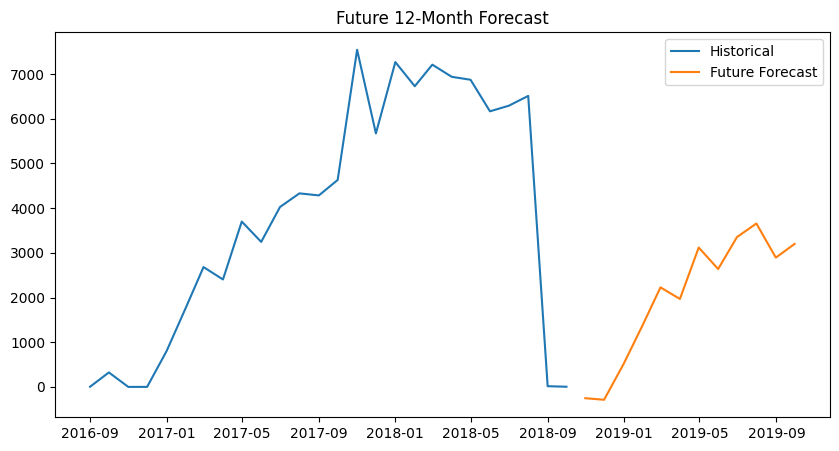

In [90]:
#final forecast using SARIMA

final_model = SARIMAX(
    monthly["y"],
    order=(1,1,1),
    seasonal_order=(1,1,1,12)
).fit()

future_forecast = final_model.forecast(12)

plt.figure(figsize=(10,5))
plt.plot(monthly["ds"], monthly["y"], label="Historical")
plt.plot(pd.date_range(monthly["ds"].iloc[-1], periods=12, freq="ME"),
         future_forecast,
         label="Future Forecast")
plt.legend()
plt.title("Future 12-Month Forecast")
plt.show()